In [57]:
##
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA
# from sklearn.pipeline import Pipeline
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

# df = pd.read_csv("./cleaned_soccer_data_v1.csv",index_col=0)
# df = pd.read_csv("../../datasets/cleaned_soccer_data_2016_v2.csv",index_col=0)
df = pd.read_csv("../../datasets/cleaned_soccer_data_120K.csv")

print(df.head())
print(df.columns)
print(df["player_positions"])


   sofifa_id         short_name                            long_name  \
0     158023           L. Messi       Lionel Andrés Messi Cuccittini   
1      20801  Cristiano Ronaldo  Cristiano Ronaldo dos Santos Aveiro   
2       9014          A. Robben                         Arjen Robben   
3      41236     Z. Ibrahimović                   Zlatan Ibrahimović   
4     167495           M. Neuer                         Manuel Neuer   

          dob  height_cm  weight_kg  overall  potential  weak_foot  \
0  1987-06-24        169         67       93         95          3   
1  1985-02-05        185         80       92         92          4   
2  1984-01-23        180         80       90         90          2   
3  1981-10-03        195         95       90         90          4   
4  1986-03-27        193         92       90         90          4   

   skill_moves  ...  rwb  lb  lcb  cb  rcb  rb   gk  player_positions  \
0            4  ...   62  54   45  45   45  54    0                CF   


In [58]:
player_positions_general=df["player_positions_general"]
player_positions_detailed = df["player_positions"]
fifa_id = df["sofifa_id"]

In [122]:
# # take only one position
# player_positions_detailed_org = df["player_positions"]
# df["player_positions"] = df["player_positions"].apply(lambda x: x.split()[-1]).astype('category')

# # print(df["player_positions"].cat.codes)
# # print(df["player_positions"].cat.categories)
# player_positions_detailed = df["player_positions"] # save for use later
# for i in df["player_positions"].unique():
#     print(i)

# player_positions_detailed

# # player_pos_codes = df["player_positions"]

CB
LB
RB
LM
CM
CAM
CDM
LWB
ST
RW
RM
CF
GK
RWB
LW


0        CB
1        LB
2        RB
3        CB
4        LM
       ... 
6353    CAM
6354     ST
6355     RM
6356     LW
6357     LB
Name: player_positions, Length: 6358, dtype: category
Categories (15, object): ['CAM', 'CB', 'CDM', 'CF', ..., 'RM', 'RW', 'RWB', 'ST']

In [123]:
# GK = set(['GK'])
# DEF = set(['LWB', 'RWB', 'LB', 'CB', 'RB'])
# MID = set(['CAM','CDM', 'LM', 'CM', 'RM'])
# ATK = set(['ST', 'LW', 'CF', 'RW'])

# # sort positions into general position labels
# def general_positions(pos):
#     if pos in GK:
#         return "GK"
#     elif pos in DEF:
#         return "DEF"
#     elif pos in ATK:
#         return "ATK"
#     elif pos in MID:
#         return "MID"
#     else:
#         return "UNK"

# player_positions_general = player_positions_detailed.apply(general_positions).astype('category')
# player_positions_general

0       DEF
1       DEF
2       DEF
3       DEF
4       MID
       ... 
6353    MID
6354    ATK
6355    MID
6356    ATK
6357    DEF
Name: player_positions, Length: 6358, dtype: category
Categories (4, object): ['ATK', 'DEF', 'GK', 'MID']

In [124]:
# player_positions_general.isnull().values.any()

False

In [126]:
# df["player_positions_general"]=player_positions_general
# df["player_positions"]=player_positions_detailed_org

# df.to_csv("./cleaned_soccer_data_2016_v3_with general_labels.csv")
# df


In [59]:
# drop features that do not mean anything
ohe_positions = ['ls', 'st', 'rs', 'lw', 'lf', 'cf',
       'rf', 'rw', 'lam', 'cam', 'ram', 'lm', 'lcm', 'cm', 'rcm', 'rm', 'lwb',
       'ldm', 'cdm', 'rdm', 'rwb', 'lb', 'lcb', 'cb', 'rcb', 'rb']
df = df.drop("player_positions",1)
df = df.drop("player_positions_general",1)
# player_fifa_id=df["player_fifa_api_id"]
# df = df.drop("player_fifa_api_id",1)
# df = df.drop("player_api_id",1)
# df = df.drop("id",1)
# df = df.drop("player_name",1)
# df = df.drop("date",1)
df = df.drop(['sofifa_id','short_name','long_name','dob','fifa'],1)

In [46]:
# drop if we dont want features in the labels
# df = df.drop(ohe_positions,1)

In [47]:
# drop binary features for better visualization
binary_features= ["preferred_foot_left",
"preferred_foot_right",
	"attacking_work_rate_high",
    	"attacking_work_rate_low",
        	"attacking_work_rate_medium",
            	"defensive_work_rate_high",
                	"defensive_work_rate_low",
                    	"defensive_work_rate_medium"
]
# df = df.drop(binary_features,1)

In [60]:
# ensure all columns are numeric
print(df.dtypes)

height_cm    int64
weight_kg    int64
overall      int64
potential    int64
weak_foot    int64
             ...  
lcb          int64
cb           int64
rcb          int64
rb           int64
gk           int64
Length: 79, dtype: object


In [61]:
# normalise before doing PCA otherwise variance is unbalanced
'''
 Normalization usually means to scale a variable to have a 
 values between 0 and 1, while standardization transforms 
 data to have a mean of zero and a standard deviation of 1
 
 Sklearn PCA only centers the variables. So the sklearn PCA does not feature scale the data beforehand.
 
 Centering a variable is subtracting the mean of the variable from each data point so that the new variable's mean is 0; 
 scaling a variable is multiplying each data point  by a constant in order to alter the range of the data.
'''

#IMPT
def normalize(df):
    return (df-df.min())/(df.max()-df.min()) 

df = normalize(df)

print(df.head())




   height_cm  weight_kg   overall  potential  weak_foot  skill_moves  \
0   0.283019   0.295082  0.981481   1.000000       0.50         0.75   
1   0.584906   0.508197  0.962963   0.945455       0.75         1.00   
2   0.490566   0.508197  0.925926   0.909091       0.25         0.75   
3   0.773585   0.754098  0.925926   0.909091       0.75         0.75   
4   0.735849   0.704918  0.925926   0.909091       0.75         0.00   

       pace  shooting   passing  dribbling  ...       ldm       cdm       rdm  \
0  0.958763  0.956989  0.924731   1.000000  ...  0.712644  0.712644  0.712644   
1  0.958763  1.000000  0.870968   0.947917  ...  0.724138  0.724138  0.724138   
2  0.958763  0.924731  0.892473   0.958333  ...  0.735632  0.735632  0.735632   
3  0.783505  0.978495  0.870968   0.895833  ...  0.747126  0.747126  0.747126   
4  0.000000  0.000000  0.000000   0.000000  ...  0.000000  0.000000  0.000000   

        rwb        lb       lcb        cb       rcb        rb   gk  
0  0.704545

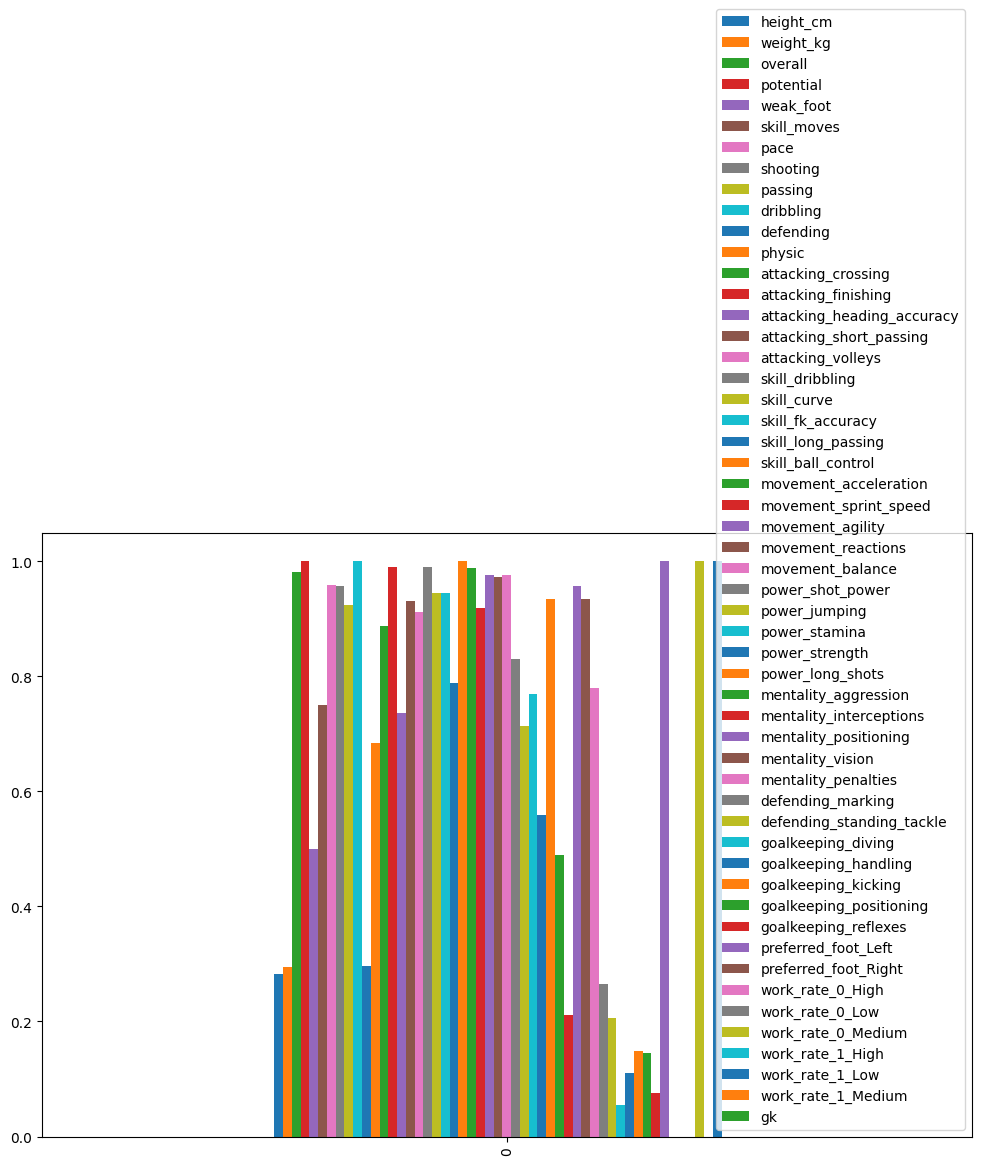

In [15]:
# visualization
# https://towardsdatascience.com/the-art-of-effective-visualization-of-multi-dimensional-data-6c7202990c57

def single_player(df):
    ax = df.iloc[[0]].plot.bar()
    plt.show()

# single_player(df)

In [73]:
def hist_plot_1d(df):
    df.hist(bins=15, color='steelblue', edgecolor='black', linewidth=1.0,
            xlabelsize=8, ylabelsize=8, grid=False)    
    plt.tight_layout(rect=(0, 0, 1.2, 1.2))   
    plt.show()

# hist_plot_1d(df)

In [74]:
# may need to drop binary features to see heatmap better
# df = df.drop(binary_features,1)
def corr_mat(df):
    f, ax = plt.subplots(figsize=(10, 6))
    corr = df.corr()
    hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
                    linewidths=.05)
    f.subplots_adjust(top=0.93)
    t= f.suptitle('Soccer Player Attributes Correlation Heatmap', fontsize=14)
    plt.show()

# corr_mat(df)

[pca] >Processing dataframe..
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [79] columns of the input data.
[pca] >Fitting using PCA..
[pca] >Computing loadings and PCs..
[pca] >Computing explained variance..
[pca] >Number of components is [13] that covers the [95.00%] explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[5]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


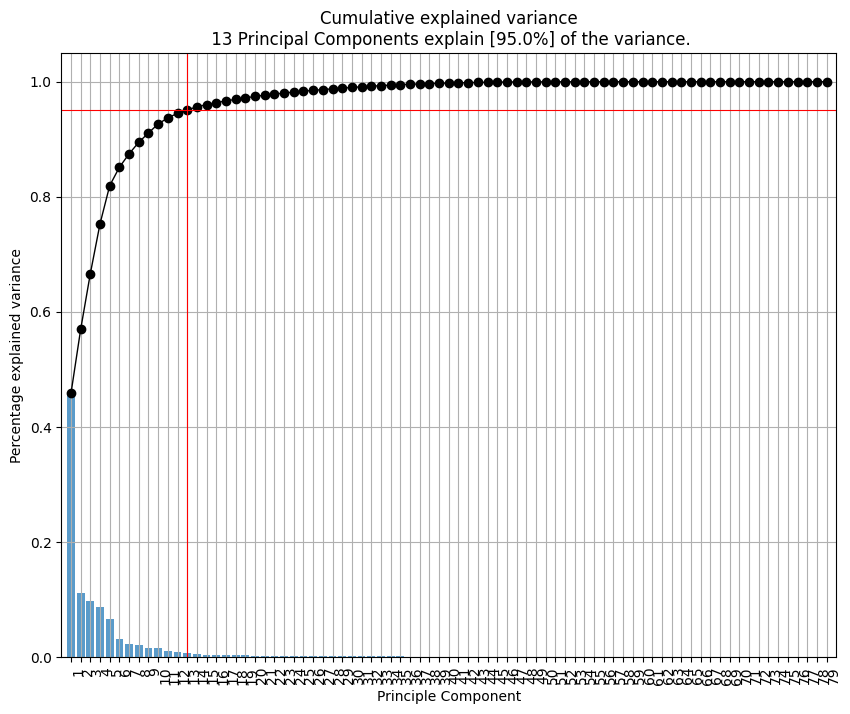

<Figure size 1200x800 with 0 Axes>

In [62]:
# pca? https://builtin.com/data-science/step-step-explanation-principal-component-analysis
# https://towardsdatascience.com/pca-clearly-explained-how-when-why-to-use-it-and-feature-importance-a-guide-in-python-7c274582c37e

'''
So, the idea is 10-dimensional data gives you 10 principal components,
 but PCA tries to put maximum possible information in the first component, 
 then maximum remaining information in the second and so on

 The resulting projected data are essentially linear combinations of 
 the original data capturing most of the variance in the data



 If you don't have any strict constraints, I recommend plotting the cumulative sum 
 of eigenvalues (assuming they are in descending order). 
 If you divide each value by the total sum of eigenvalues 
 prior to plotting, then your plot will show the fraction 
 of total variance retained vs. number of eigenvalues. 
 The plot will then provide a good indication of when you 
 hit the point of diminishing returns 
 (i.e., little variance is gained by retaining additional 
 eigenvalues).

 Reduce dimensions due to the Curse of Dimensionality

 If the PCA display* our K clustering result to be orthogonal or close to, then it is a sign that our clustering 
 is sound , each of which exhibit unique characteristics
'''

def check_n_pcs(df):
    from pca import pca #nicer library but bottom part does not work
    model = pca(n_components=0.95) # gives 14pcs
    model.fit_transform(df)
    # Initialize to reduce the data up to the number of componentes that explains 95% of the variance n_pc=16.
    fig, ax = model.plot()
    plt.show()

check_n_pcs(df)




In [63]:
num_pc=13
pca = PCA(n_components=num_pc)
# pca.fit(df)
df_pca = pca.fit_transform(df)

# print(pca.components_) #eigenvectors pca.components_ has shape [n_components, n_features]
# print(pca.explained_variance_) #eigenvalues
# plt.plot(pca.explained_variance_)
# plt.show() # diminishing returns at 6 PCs
print(pca.explained_variance_ratio_)


[0.45806552 0.11129034 0.09718378 0.08658563 0.06622924 0.03205941
 0.02323803 0.02015896 0.01608466 0.01574999 0.01046871 0.0080168
 0.00608425]


<ipython-input-27-4ec47ff7b1e6>:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  def scatter_pca_sns(df,df_pca,num_pc,labels=pd.Series()):


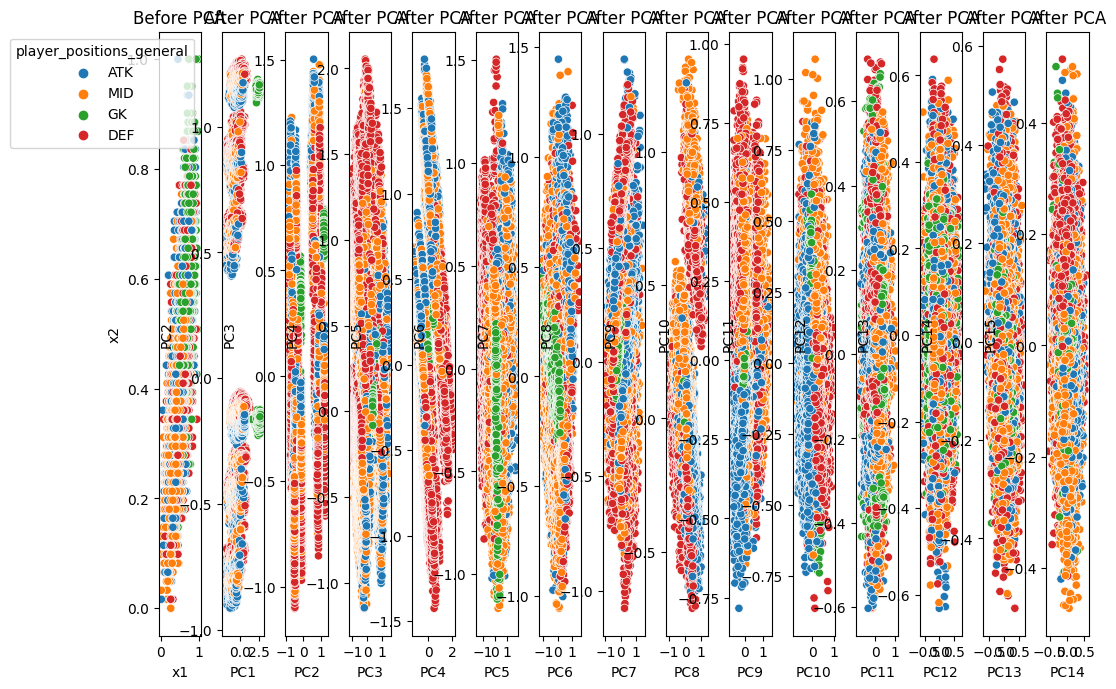

In [27]:


def scatter_pca_sns(df,df_pca,num_pc,labels=pd.Series()):
    fig, axes = plt.subplots(1,num_pc)
    if not labels.empty:
        sns.scatterplot(data=df, x=df.iloc[:,0], y=df.iloc[:,1], hue=labels,ax=axes[0])
    else:
        sns.scatterplot(data=df, x=df.iloc[:,0], y=df.iloc[:,1],ax=axes[0])
    axes[0].set_xlabel('x1')
    axes[0].set_ylabel('x2')
    axes[0].set_title('Before PCA')
    for i in range(1,num_pc):
        if not labels.empty:
            sns.scatterplot(data=df_pca, x=df_pca[:,i-1], y=df_pca[:,i], hue=labels,ax=axes[i],legend=False)
        else:
            sns.scatterplot(data=df, x=df_pca[:,i-1], y=df_pca[:,i],ax=axes[i],legend=False)
        axes[i].set_xlabel('PC{}'.format(i))
        axes[i].set_ylabel('PC{}'.format(i+1))
        axes[i].set_title('After PCA')
    plt.subplots_adjust(wspace=0.5)
    plt.show()
    
# scatter_pca_sns(df,df_pca,num_pc,labels=player_positions_detailed)
scatter_pca_sns(df,df_pca,num_pc,labels=player_positions_general)


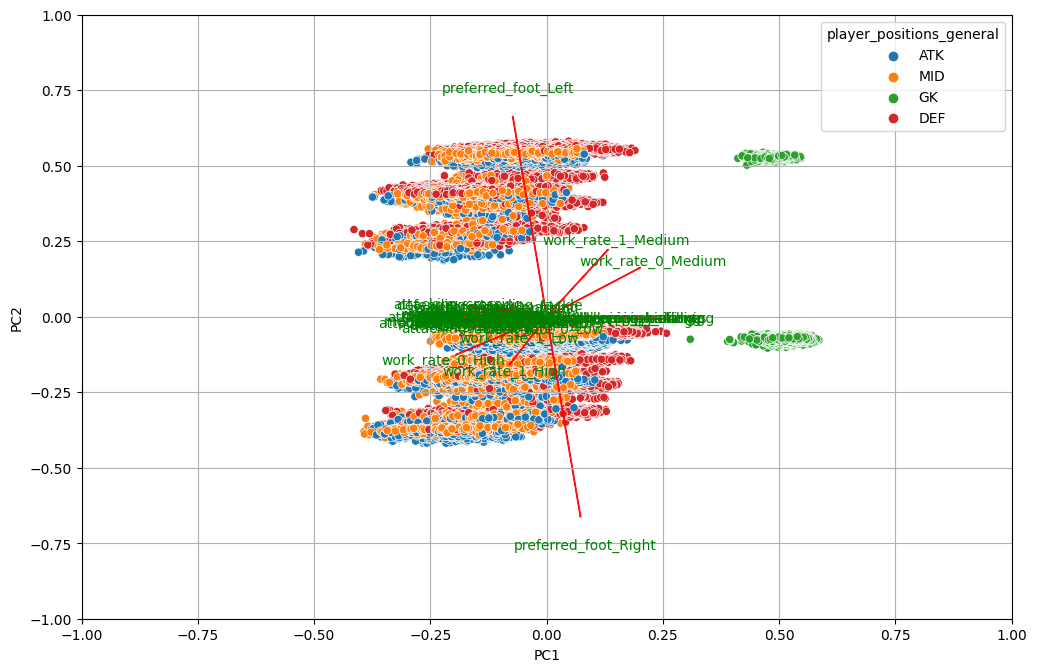

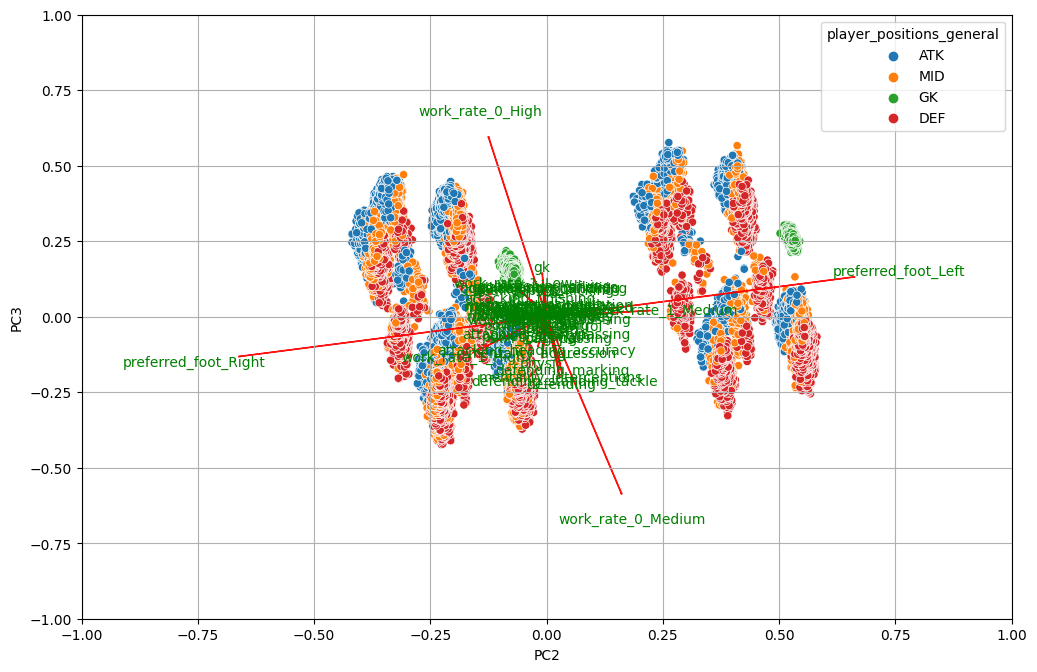

In [29]:

def biplot(df,score,coeff,num_pc,labels=None):
    '''
    score: the projected data
    coeff: the eigenvectors (PCs)
    pcax: pca1 index
    pcay: pca2 index
    '''
    for i in range(0,num_pc-1):
        pca1=i
        pca2=i+1
        xs = score[:,i]
        ys = score[:,i+1]
        n=coeff.shape[0]
        scalex = 1.0/(xs.max()- xs.min())
        scaley = 1.0/(ys.max()- ys.min())
        if labels is None:
            sns.scatterplot(data=score, x=xs*scalex, y=ys*scaley)
        else:
            sns.scatterplot(data=score, x=xs*scalex, y=ys*scaley, hue=labels)
        for j in range(n): #feature explain variance
            plt.arrow(0, 0, coeff[j,pca1], coeff[j,pca2],color='r',alpha=0.9) 
            if labels is None:
                plt.text(coeff[j,pca1]* 1.15, coeff[j,pca2] * 1.15,  list(df.columns)[j], color='g', ha='center', va='center')
            else:
                plt.text(coeff[j,pca1]* 1.15, coeff[j,pca2] * 1.15, list(df.columns)[j], color='g', ha='center', va='center')
        plt.xlim(-1,1)
        plt.ylim(-1,1)
        plt.xlabel("PC{}".format(pca1+1))
        plt.ylabel("PC{}".format(pca2+1))
        plt.grid()
        plt.show()

# Call the biplot function for any number of PCs
biplot(df,df_pca, np.transpose(pca.components_),3,player_positions_general)



In [64]:
# check if plot is correct
# Var 33 and Var 31 are extremely positively correlated
# print(np.corrcoef(df.iloc[:,33], df.iloc[:,31])[1,0])
# Var 36 and Var 37 are negatively correlated
print(np.corrcoef(df.loc[:,"preferred_foot_Right"], df.loc[:,"preferred_foot_Left"])[1,0] )

-1.0


In [65]:
# normalize pca to unit norm
from sklearn import preprocessing
df_pca = preprocessing.normalize(df_pca, norm='l2')

In [66]:
columns=["PC{}".format(i) for i in range(1,num_pc+1)]
df_pca = pd.DataFrame(df_pca,columns=columns,index=df.index)
df_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13
0,-0.659803,-0.282047,0.283282,-0.228453,0.511432,0.144032,0.167853,-0.079295,-0.039332,0.109487,-0.145284,0.014578,-0.032331
1,-0.740496,-0.495468,-0.197530,0.012967,0.205035,0.134539,0.267429,-0.011470,-0.011156,-0.025109,-0.172944,0.059154,0.032214
2,-0.711020,-0.489479,0.265827,0.115584,0.289739,0.118654,0.202991,-0.095863,-0.023840,0.056658,-0.080416,-0.006659,-0.110114
3,-0.658700,-0.187785,-0.205507,-0.279995,0.437165,0.183326,0.393220,0.090353,-0.033021,-0.050761,-0.124458,0.043634,0.040665
4,0.916587,-0.116570,-0.030168,0.046581,0.020551,0.195405,0.056546,-0.010370,-0.113861,-0.042460,-0.137003,0.252994,0.061202


In [67]:
r = df_pca.iloc[0,:].apply(lambda x: x**2)
np.sum(r)

0.9999999999999999

In [68]:
df_final = df_pca
df_final["player_fifa_api_id"]=fifa_id
df_final["player_positions"] = player_positions_detailed
df_final["player_positions_general"] = player_positions_general
df_final.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,player_fifa_api_id,player_positions,player_positions_general
0,-0.659803,-0.282047,0.283282,-0.228453,0.511432,0.144032,0.167853,-0.079295,-0.039332,0.109487,-0.145284,0.014578,-0.032331,158023,CF,ATK
1,-0.740496,-0.495468,-0.197530,0.012967,0.205035,0.134539,0.267429,-0.011470,-0.011156,-0.025109,-0.172944,0.059154,0.032214,20801,"LW, LM",ATK
2,-0.711020,-0.489479,0.265827,0.115584,0.289739,0.118654,0.202991,-0.095863,-0.023840,0.056658,-0.080416,-0.006659,-0.110114,9014,"RM, LM, RW",MID
3,-0.658700,-0.187785,-0.205507,-0.279995,0.437165,0.183326,0.393220,0.090353,-0.033021,-0.050761,-0.124458,0.043634,0.040665,41236,ST,ATK
4,0.916587,-0.116570,-0.030168,0.046581,0.020551,0.195405,0.056546,-0.010370,-0.113861,-0.042460,-0.137003,0.252994,0.061202,167495,GK,GK


In [69]:
df_final.to_csv("./soccer_player_embeddings_feature_labels_120K.csv")
# df_final.to_csv("./soccer_player_embeddings_feature_labels.csv")
# combinations

# multi class classification for neural net
# https://towardsdatascience.com/pytorch-tabular-multiclass-classification-9f8211a123ab